### Imports

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import lang2vec.lang2vec as l2v
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import chi2_contingency
from datetime import datetime

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth',None)
NFOLDS = 10
SEED = 7

### Set arguments

At a later stage the parameters below can become argparse parameters

In [3]:
overwrite_chi2 = False
remove_correlated = False
encoding = "onehot"
use_syn_dist=False
remove_weird_pairs = True
is_same = False
selection = "all"
analyze_dataset_size = Falsewe

### Load data

#### Load table with language features

In [5]:
lang_feats = pd.read_excel("../../xtreme_langs_wals.xlsx", index_col=0)

In [11]:
lang_feats.shape

(40, 185)

Display unique values of selected features

#### Load language pairs with scores

In [13]:
pair_scores = pd.read_csv("lang_pair_scores.csv")

In [73]:
if analyze_dataset_size:
    lang_size = pd.read_excel("../../xtreme_langs_wals_with_data_size.xlsx", index_col=0)
    lang_size = lang_feats[["Name","wals_code"]].merge(lang_size[["Name","# tokens in UD (in thousands)"]], on="Name",right_index=True)
    lang_size = lang_size[lang_size['# tokens in UD (in thousands)']!='-']

    corr_size = pair_scores.copy()
    corr_size["train_size"] = 0
    corr_size["test_size"] = 0

    for i in corr_size.index:
        corr_size.at[i,"train_size"] = lang_size.at[corr_size.at[i,"train_lang"],"# tokens in UD (in thousands)"]
        corr_size.at[i,"test_size"] = lang_size.at[corr_size.at[i,"test_lang"],"# tokens in UD (in thousands)"]

    corr_size = corr_size[corr_size.train_lang!=corr_size.test_lang]
    removed_pairs = (corr_size.train_lang.isin(['ja','zh'])) | (corr_size.test_lang.isin(['fr','ja','zh'])) | ((corr_size.train_lang=='de')&(corr_size.test_lang=='en'))
    corr_size = corr_size[~removed_pairs]

    from scipy import stats

    print(stats.pearsonr(corr_size['acc'], corr_size['train_size']))
    print(stats.pearsonr(corr_size['acc'], corr_size['test_size']))

    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='train_size',y='acc',data=corr_size)
    plt.show()

    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='test_size',y='acc',data=corr_size)
    plt.show()

In [16]:
feat_cols = lang_feats.dropna(axis=1,how='all').columns[12:]

In [ ]:
feat_cols

### Feature correlation

In [14]:
if overwrite_chi2:
    chi2 = {"col1":[],"col2":[],"chi2":[],"p":[],"result":[]}
    alpha = 0.05

    for i, col1 in enumerate(feat_cols):
        for j, col2 in enumerate(feat_cols):
            if i<j:
                table = pd.crosstab(lang_feats[col1],lang_feats[col2])
                try:
                    chi, p, dof, expected = chi2_contingency(table)
                except:
                    print("Error", col1, col2)
                    continue

                if p <= alpha:
                    result = 'Dependent (reject H0)'
                else:
                    result = 'Independent (fail to reject H0)'
                chi2["col1"].append(col1)
                chi2['col2'].append(col2)
                chi2['chi2'].append(chi)
                chi2['p'].append(p)
                chi2['result'].append(result)
    chi2 = pd.DataFrame.from_dict(chi2)
    chi2.to_csv("chi_correlations.csv")
else:
    chi2 = pd.read_csv("chi_correlations.csv")
    
chi2.head()

,col1,col2,chi2,p,result
0,20A Fusion of Selected Inflectional Formatives,21A Exponence of Selected Inflectional Formatives,10.492063,0.572875,Independent (fail to reject H0)
1,20A Fusion of Selected Inflectional Formatives,22A Inflectional Synthesis of the Verb,20.773449,0.187384,Independent (fail to reject H0)
2,20A Fusion of Selected Inflectional Formatives,23A Locus of Marking in the Clause,16.924242,0.152469,Independent (fail to reject H0)
3,20A Fusion of Selected Inflectional Formatives,24A Locus of Marking in Possessive Noun Phrases,32.711111,0.008069,Dependent (reject H0)
4,20A Fusion of Selected Inflectional Formatives,25A Locus of Marking: Whole-language Typology,25.714286,0.011778,Dependent (reject H0)


In [15]:
chi2.sort_values(by="chi2",ascending=False).head(10)

,col1,col2,chi2,p,result
12106,"144A Position of Negative Word With Respect to Subject, Object, and Verb",143A Order of Negative Morpheme and Verb,166.956522,8.092382e-17,Dependent (reject H0)
7918,"81A Order of Subject, Object and Verb","144A Position of Negative Word With Respect to Subject, Object, and Verb",93.367347,4.210062e-11,Dependent (reject H0)
945,26A Prefixing vs. Suffixing in Inflectional Morphology,33A Coding of Nominal Plurality,84.576087,2.465659e-11,Dependent (reject H0)
4297,49A Number of Cases,"144A Position of Negative Word With Respect to Subject, Object, and Verb",80.337088,3.156887e-03,Dependent (reject H0)
12398,143A Order of Negative Morpheme and Verb,144L The Position of Negative Morphemes in SOV Languages,80.000000,1.141061e-07,Dependent (reject H0)
4313,49A Number of Cases,143A Order of Negative Morpheme and Verb,76.353846,9.347842e-04,Dependent (reject H0)
9131,95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase,97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun,73.350000,2.565681e-09,Dependent (reject H0)
11885,143F Postverbal Negative Morphemes,143A Order of Negative Morpheme and Verb,72.000000,1.350727e-10,Dependent (reject H0)
12369,143E Preverbal Negative Morphemes,143A Order of Negative Morpheme and Verb,72.000000,1.350727e-10,Dependent (reject H0)
10453,112A Negative Morphemes,"144A Position of Negative Word With Respect to Subject, Object, and Verb",71.500000,1.145492e-05,Dependent (reject H0)


In [17]:
feat_cols = list(feat_cols)

In [17]:
chi2.result.value_counts()

Independent (fail to reject H0)    10965
Dependent (reject H0)               1543
Name: result, dtype: int64

In [18]:
if remove_correlated:
    correlated = chi2[chi2.result=="Dependent (reject H0)"].col2.unique()
    for feat in correlated:
        feat_cols.remove(feat)

In [75]:
pair_scores.columns

Index(['train_lang', 'test_lang', 'acc', 'f1'], dtype='object')

In [18]:
final_arr = []


if is_same:
    for i in pair_scores.index:
        train_lang = pair_scores.at[i,"train_lang"]
        test_lang = pair_scores.at[i,"test_lang"]
        
        switched_acc = pair_scores[(pair_scores.train_lang==test_lang)&(pair_scores.test_lang==train_lang)].acc.values[0]
        avg_acc = (switched_acc+pair_scores.at[i,"acc"])/2
        
        switched_f1 = pair_scores[(pair_scores.train_lang==test_lang)&(pair_scores.test_lang==train_lang)].f1.values[0]
        avg_f1 = (switched_acc+pair_scores.at[i,"f1"])/2
        
        train_feats = [train_lang, test_lang,avg_acc, avg_f1] + list((lang_feats.loc[train_lang,feat_cols]==lang_feats.loc[test_lang,feat_cols]).values)
        final_arr.append(train_feats)
        
    feat_cols = ["is_"+col.split()[0]+"_same" for col in feat_cols]
else:
    for i in pair_scores.index:
        train_lang = pair_scores.at[i,"train_lang"]
        test_lang = pair_scores.at[i,"test_lang"]
        train_feats =  list(pair_scores.iloc[i,:].values) + list(lang_feats.loc[train_lang,feat_cols].values) + list(lang_feats.loc[test_lang,feat_cols].values)
        final_arr.append(train_feats)
        
    feat_cols = [col.split()[0]+"_train" for col in feat_cols]+ [col.split()[0]+"_test" for col in feat_cols]
    
final_cols = list(pair_scores.columns)+feat_cols

final_df = pd.DataFrame(data=final_arr,columns=final_cols)

In [19]:
final_df = final_df.drop_duplicates(subset='acc')

In [20]:
final_df.shape

(827, 324)

In our experiments it appears that the performance improved when we exclude pairs when the same language is used for training and testing. Therefore we remove them here.

In [151]:
final_df = final_df[final_df['train_lang']!=final_df['test_lang']]

### Kruskal correlation between target and every feature per lang

In [21]:
import scipy.stats as stats
def kruskal_per_lang(x):
    kruskal = {"test_lang":[],"feature":[],"h":[],"p":[],"result":[]}
    alpha = 0.05
    test_feats = [col for col in x.columns if "_train" in col]
    assert len(test_feats)>0,"Set is_same to False"
    test_lang = x.iat[0,1]
    for col in test_feats:
        col_df = x[[col,'acc']].dropna()
        if col_df[col].nunique()>1:
            groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
            h, p = stats.kruskal(*groups)
            if p<alpha:
                result = 'Dependent (reject H0)'
            else:
                result = 'Independent (fail to reject H0)'
            kruskal["test_lang"].append(test_lang)
            kruskal['feature'].append(col)
            kruskal['h'].append(h)
            kruskal['p'].append(p)
            kruskal['result'].append(result)
    
    kruskal = pd.DataFrame.from_dict(kruskal)
    return kruskal

kruskal_test = final_df.groupby(by="test_lang").apply(kruskal_per_lang).reset_index(drop=True)
min_p_ixs = kruskal_test.groupby(by='test_lang').p.idxmin()
most_corr_per_lang = kruskal_test.loc[min_p_ixs,:]
most_corr_per_lang

,test_lang,feature,h,p,result
89,af,115A_train,13.514706,0.001162,Dependent (reject H0)
195,ar,86A_train,15.486548,0.000434,Dependent (reject H0)
334,bg,93A_train,15.766615,0.000377,Dependent (reject H0)
488,de,115A_train,13.356588,0.001258,Dependent (reject H0)
559,el,47A_train,10.632534,0.001111,Dependent (reject H0)
754,en,115A_train,10.496000,0.005258,Dependent (reject H0)
859,es,85A_train,16.007143,0.000334,Dependent (reject H0)
999,et,93A_train,14.513846,0.000705,Dependent (reject H0)
1099,eu,55A_train,12.075439,0.002387,Dependent (reject H0)
1258,fa,85A_train,16.369458,0.000279,Dependent (reject H0)


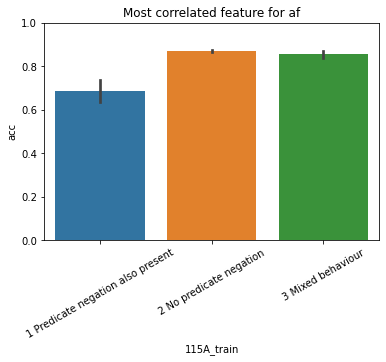

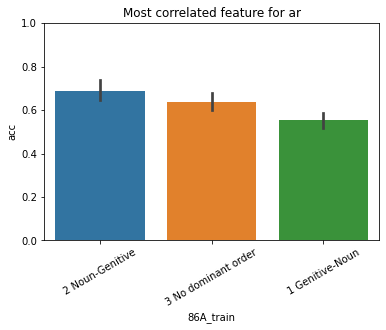

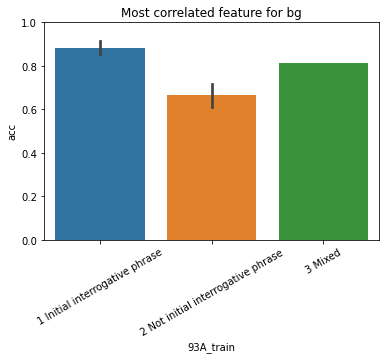

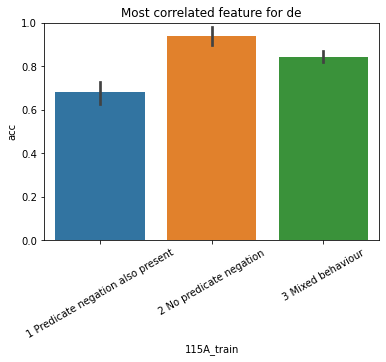

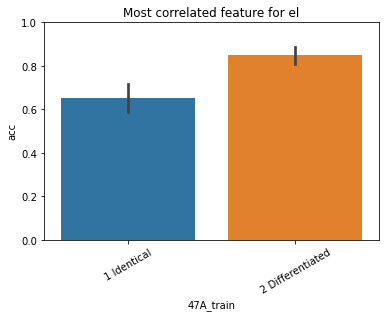

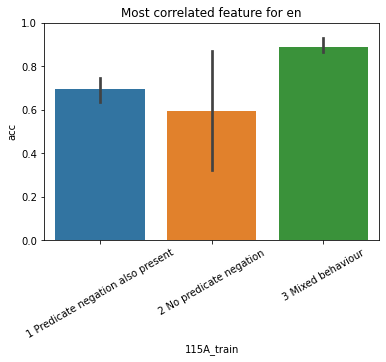

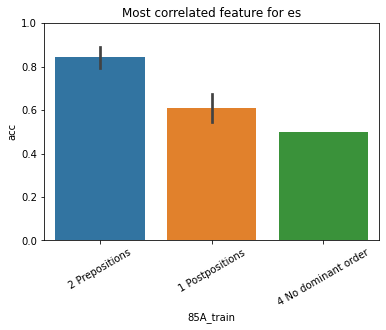

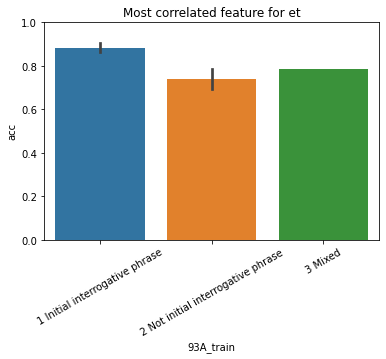

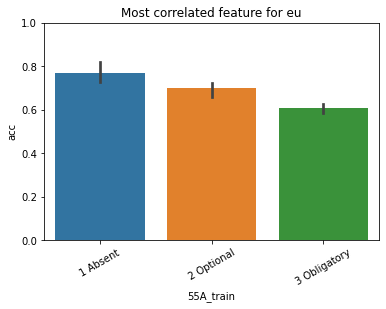

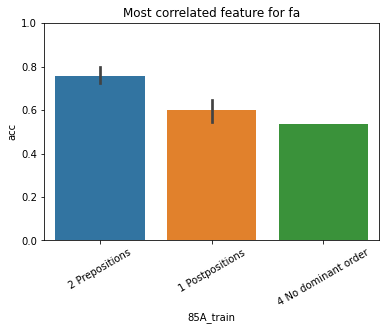

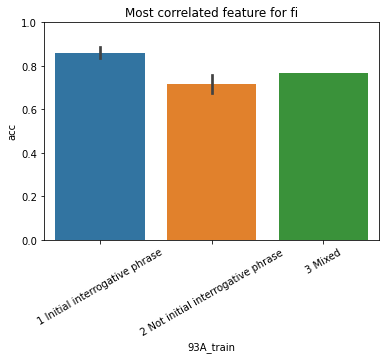

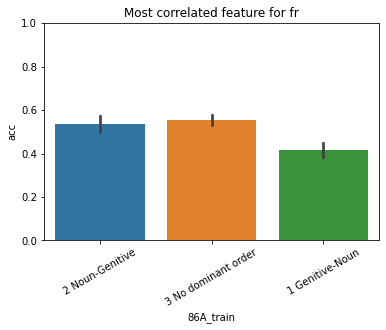

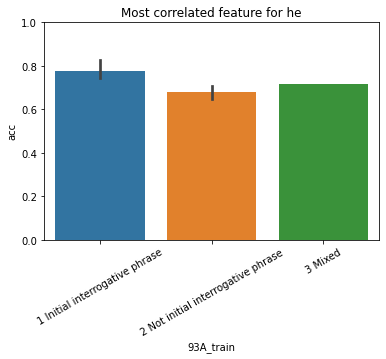

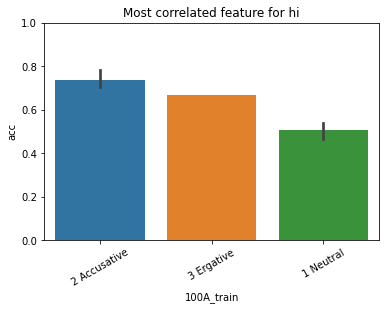

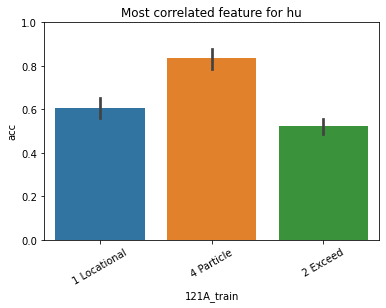

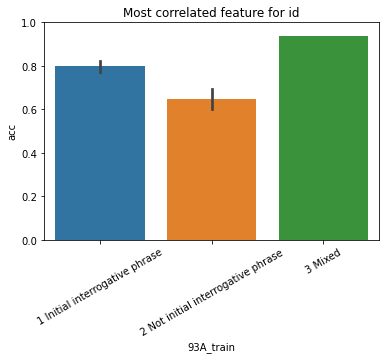

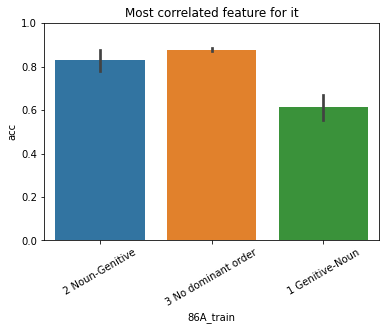

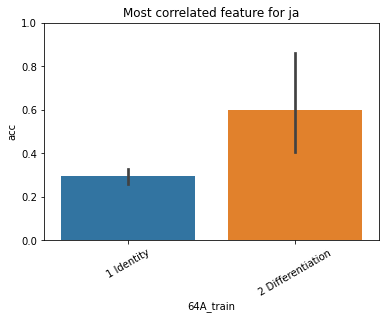

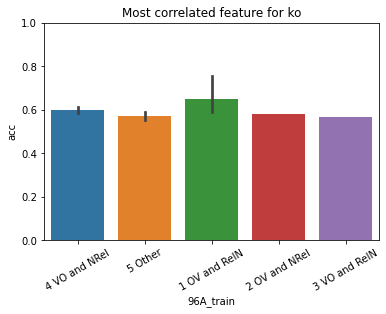

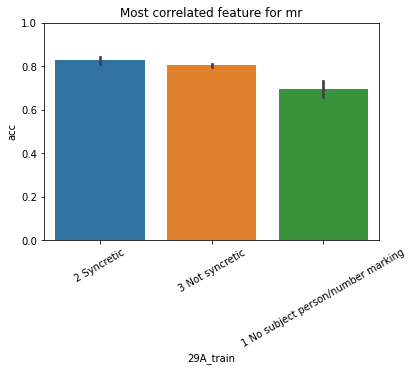

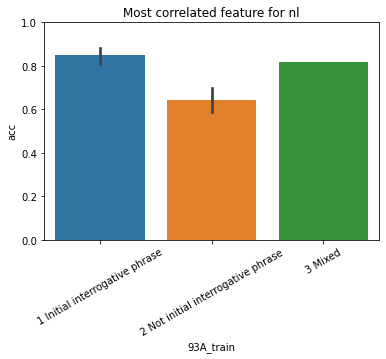

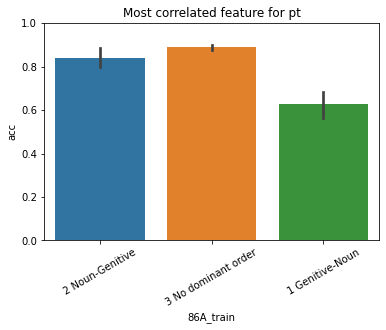

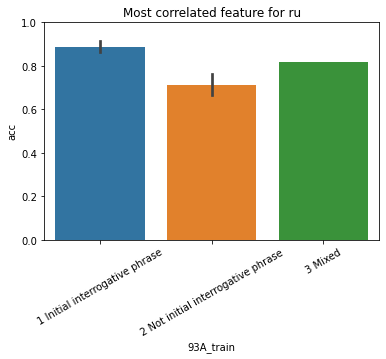

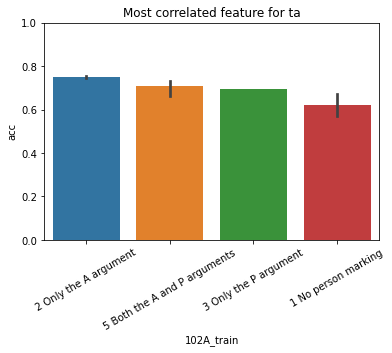

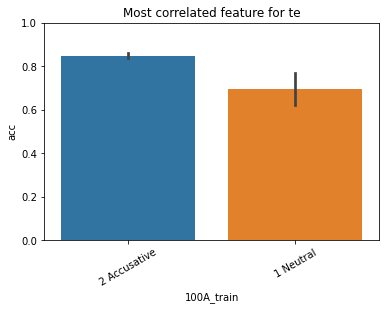

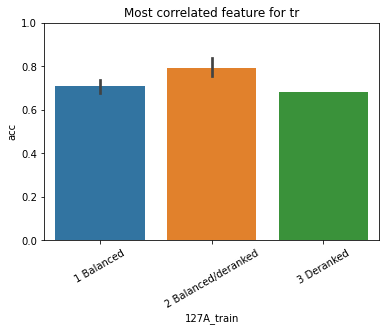

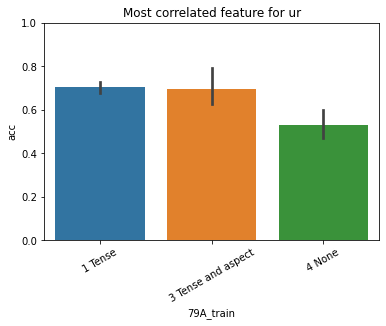

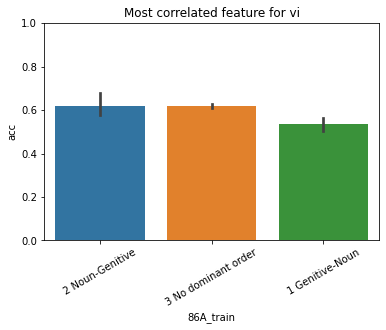

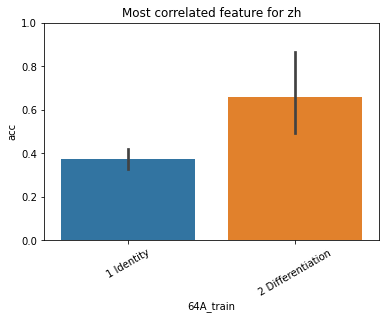

Feature 100A_train
Langs ['hi' 'te']
Feature 102A_train
Langs ['ta']
Feature 115A_train
Langs ['af' 'de' 'en']
Feature 121A_train
Langs ['hu']
Feature 127A_train
Langs ['tr']
Feature 29A_train
Langs ['mr']
Feature 47A_train
Langs ['el']
Feature 55A_train
Langs ['eu']
Feature 64A_train
Langs ['ja' 'zh']
Feature 79A_train
Langs ['ur']
Feature 85A_train
Langs ['es' 'fa']
Feature 86A_train
Langs ['ar' 'fr' 'it' 'pt' 'vi']
Feature 93A_train
Langs ['bg' 'et' 'fi' 'he' 'id' 'nl' 'ru']
Feature 96A_train
Langs ['ko']


In [22]:
import seaborn as sns

def plot_most_corr(x):
    test_lang = x.iat[0,0]
    most_corr_feat = x.iat[0,1]
#     if most_corr_feat=="93A_train":
    ax = sns.barplot(x=most_corr_feat, y="acc", data=final_df[final_df.test_lang==test_lang])
    plt.title("Most correlated feature for {}".format(test_lang))
    plt.xticks(rotation=30)
    plt.ylim([0,1])
    plt.show()
    
kpl = False
if kpl:    
    most_corr_per_lang.groupby(by="test_lang").apply(plot_most_corr)

#     def func(x):
#         print(x.train_lang.unique())
#     final_df.groupby(by="64A_train").apply(func)

#     langs = ['bg', 'et', 'fi', 'he', 'id', 'nl', 'ru']
#     lang_feats = lang_feats.reset_index()
#     lang_feats['93A Position of Interrogative Phrases in Content Questions']

    def output(x):
        print("Feature",x.iat[0,1])
        print("Langs",x.test_lang.unique())
    most_corr_per_lang.groupby(by="feature").apply(output)

    most_corr_per_lang['feature'].value_counts()

#     sns.barplot(most_corr_per_lang['feature'].value_counts())

In [ ]:
if kpl: 
    kruskal_per_lang(final_df).sort_values(by='p').head()

### Kruskal feature selection

In [155]:
if selection=="kruskal":
    alpha = 0.05
    dep_cols = []
    for col in feat_cols:
        col_df = final_df[[col,'acc']].dropna()
        if col_df[col].nunique()>1:
            groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
            if stats.kruskal(*groups).pvalue<alpha:
                dep_cols.append(col)

Delete features that have only missing values

### Add syntactical distance

We are using ISO 369-2 and lang2vec is using ISO 369-3, but they mostly overlap. For UD POS only Malay does not have a precomputed distance (its ISO 369-1 is "ms", ISO 369-2 is "may" and ISO 369-3 is "mly"). Therefore we delete it from the list to avoid errors.

In [156]:
if use_syn_dist:
    lang_codes_2 = list(lang_feats['ISO 693-2'].values)
    lang_codes_2.remove("may")
    lang_codes_1 = list(lang_feats.index)
    lang_codes_1.remove("ms")
    synt_dist = pd.DataFrame(data=l2v.syntactic_distance(lang_codes_2),index=lang_codes_1,columns=lang_codes_1)

    for i in final_df.index:
        train_lang = final_df.at[i,"train_lang"]
        test_lang = final_df.at[i,"test_lang"]
        try:
            final_df.at[i,"syn_dist"] =  synt_dist.at[train_lang, test_lang]
        except:
            print("Language not in URIEL")
    #       TODO: for now just add a place holder for languages that are not in the URIEL database, later compute the vectors yourself
            final_df.at[i,"syn_dist"] = -1

### Other preprocessing

#### Remove French test pairs, German-English pair and all Chinese and Japanese pairs

In [14]:
if remove_weird_pairs:
    removed_pairs = (final_df.train_lang.isin(['ja','zh'])) | (final_df.test_lang.isin(['fr','ja','zh'])) | ((final_df.train_lang=='de')&(final_df.test_lang=='en'))
    final_df = final_df[~removed_pairs]

In [15]:
final_df = final_df.dropna(axis=1,how='all')

In [16]:
lang_feats.columns

Index(['ISO 693-2', 'wals_code', 'iso_code', 'glottocode', 'Name', 'latitude',
       'longitude', 'genus', 'family', '#feats',
       ...
       '137B M in Second Person Singular', '136B M in First Person Singular',
       '109B Other Roles of Applied Objects',
       '10B Nasal Vowels in West Africa',
       '25B Zero Marking of A and P Arguments',
       '21B Exponence of Tense-Aspect-Mood Inflection',
       '108B Productivity of the Antipassive Construction',
       '130B Cultural Categories of Languages with Identity of 'Finger' and 'Hand'',
       '58B Number of Possessive Nouns',
       '79B Suppletion in Imperatives and Hortatives'],
      dtype='object', length=185)

### Fill missing values

In [17]:
cat_cols = list(final_df.select_dtypes(include=['object']).columns)

In [18]:
final_df[cat_cols] = final_df[cat_cols].fillna("0 Missing")

In [19]:
final_df.isna().any().any()

False

### Encode categorical variables (i.e. all of them)

In [20]:
if encoding=="ordinal":
    mappings = []
    for col in cat_cols:
        unique_vals = final_df[col].unique()
    #     every value starts with an index number, additionally we mark missing as 0
        sorted_vals = sorted(unique_vals, key=lambda element: [element[0]])
        mappings.append(sorted_vals)

    oe = OrdinalEncoder(categories=mappings)
    oe.fit(final_df[cat_cols])
    final_df[cat_cols] = oe.transform(final_df[cat_cols])
elif encoding=="onehot":
    from sklearn.preprocessing import OneHotEncoder

    one_hot = pd.get_dummies(final_df[cat_cols])
    final_df = final_df.drop(cat_cols,axis=1)
    final_df = pd.concat([final_df,one_hot],axis=1)
    
    cols_with_brackets = [col for col in final_df.columns if '[' in col ]
    brackets_dict = {}
    for col in cols_with_brackets:
        brackets_dict[col] = re.sub("\[|\]", "", col) # remove square brackets
    final_df = final_df.rename(columns=brackets_dict)
else:
    raise Exception("Incorrect encoding name. Choose between \"ordinal\" and \"onehot\"")

### Functions for training and evaluation

In [21]:
def fold_metrics(model, x_train, y_train, x_val, y_val, metrics_dict,debug=False): 
    y_preds = model.predict(x_train)
    fold_train = np.sqrt(mean_squared_error(y_train,y_preds))
    
    y_preds_val = model.predict(x_val)
    fold_val = np.sqrt(mean_squared_error(y_val,y_preds_val))


    
    metrics_dict['train']['rmse'].append(fold_train)
    metrics_dict['test']['rmse'].append(fold_val)
    
    if debug:
        metrics = pd.DataFrame.from_dict({'train':[fold_train],
                                         'test':[fold_val]})
        metrics.index = ['rmse']
        display(metrics)

In [22]:
def mean_fold_metrics(metrics_dict):
    
    train_rmse = np.mean(metrics_dict['train']['rmse'])
    test_rmse = np.mean(metrics_dict['test']['rmse'])
                        
    metrics = pd.DataFrame.from_dict({'train':[train_rmse],'test':[test_rmse]})
    metrics.index = ['rmse']
    
    print()
    print("Mean fold metrics")
    display(metrics)
    return metrics

In [23]:
def train_model(X, y, folds, params=None, X_test=None, model_type='lgb',n_jobs=-1, n_estimators=None, plot_feature_importance=True,save_importance = True,verbose=500,early_stopping_rounds=None):
#     add n_estimators and early_stopping as arguments in lgbm
    print("Model type",model_type)
    metrics_dict = {'train':{'rmse':[]},
                   'test':{'rmse':[]}}
    result_dict = {}
    n_splits = folds.n_splits
    columns = X.columns
    # averaged predictions on test data
    if X_test is not None:
        prediction = np.zeros((len(X_test), 1))
    
    feature_importance = pd.DataFrame()
    
    if params is None:
        params = {}
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
#         print('Fold nr {}'.format(fold_n))
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        if model_type=='lgb':
            model = lgb.LGBMClassifier(**params, importance_type='gain')
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=verbose)
    #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        elif model_type=='xgb':
            model = xgb.XGBRegressor(**params,random_state=SEED)
            model.fit(X_train, y_train)
            #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='linear':
            model = LinearRegression()
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='lasso':
            model = Lasso(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='dt':
            model = DecisionTreeRegressor(max_depth=10,max_leaf_nodes=10,random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='rf':
            model = RandomForestRegressor(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        else:
            raise Exception("Invalid model type")
                    
        fold_metrics(model,X_train,y_train,X_valid,y_valid,metrics_dict)
        
        if X_test is not None:
            prediction += y_pred.reshape(-1, 1)
        if plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    
    if X_test is not None:
        prediction /= n_splits
    
    result_dict['metrics'] = mean_fold_metrics(metrics_dict)
    if X_test is not None:
        result_dict['prediction'] = prediction.flatten()
        
    
    if plot_feature_importance:
        feature_importance["importance"] /= n_splits
        best_features = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].reset_index(level=['feature'])


        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features);
        plt.title('{} Features (avg over folds) overwrite_chi2 = {} remove_correlated = {} encoding = {} use_syn_dist = {} remove_weird_pairs = {}'.format(model_type.upper(),
                                                    overwrite_chi2,
                                                    remove_correlated,
                                                    encoding,
                                                    use_syn_dist,
                                                    remove_weird_pairs));
        
        if save_importance:
            now = datetime.now() 
            now = now.strftime("%d_%m_%Y_%H_%M")
            plt.savefig("Feature importance {}.jpg".format(now),dpi=500, bbox_inches='tight')
        
        result_dict['feature_importance'] = feature_importance
        result_dict['top_columns'] = best_features['feature'].unique()
        
    return result_dict, model

### Train models

In [24]:
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

#### On all features

In [ ]:
# X = final_df.drop(['acc','f1','syn_dist'],axis=1)
if selection=="all":
    if use_syn_dist:
        X = final_df.drop(['acc','f1','syn_dist'],axis=1)
    else:
        X = final_df.drop(['acc','f1'],axis=1)
    y = final_df['acc']
elif selection=="kruskal":
    X = final_df[dep_cols]
    y = final_df['acc']
elif selection=="stepwise":
    X = final_df[best_stepwise]
    y = final_df['acc']

In [55]:
for feat in ['144N_test', '143B_test', '143B_train', '144N_train']:
    mrmr_top50.remove(feat)

Try different models and compare results

In [170]:
final_df.head()

,train_lang,test_lang,acc,f1,train_size,test_size,20A_train,21A_train,22A_train,23A_train,24A_train,25A_train,26A_train,27A_train,28A_train,29A_train,30A_train,31A_train,32A_train,33A_train,34A_train,35A_train,36A_train,37A_train,38A_train,39A_train,40A_train,41A_train,42A_train,43A_train,44A_train,45A_train,46A_train,47A_train,48A_train,49A_train,50A_train,51A_train,52A_train,53A_train,54A_train,55A_train,56A_train,57A_train,58A_train,59A_train,60A_train,61A_train,62A_train,63A_train,64A_train,65A_train,66A_train,67A_train,68A_train,69A_train,70A_train,71A_train,72A_train,73A_train,74A_train,75A_train,76A_train,77A_train,78A_train,79A_train,80A_train,81A_train,82A_train,83A_train,84A_train,85A_train,86A_train,87A_train,88A_train,89A_train,90A_train,91A_train,92A_train,93A_train,94A_train,95A_train,96A_train,97A_train,98A_train,99A_train,100A_train,101A_train,102A_train,103A_train,104A_train,105A_train,106A_train,107A_train,108A_train,109A_train,110A_train,111A_train,112A_train,113A_train,114A_train,115A_train,116A_train,117A_train,118A_train,119A_train,120A_train,121A_train,122A_train,123A_train,124A_train,125A_train,126A_train,127A_train,128A_train,129A_train,130A_train,131A_train,132A_train,133A_train,134A_train,135A_train,136A_train,137A_train,138A_train,142A_train,143F_train,90B_train,90C_train,144P_train,144J_train,144S_train,144X_train,144A_train,90E_train,144V_train,144I_train,144R_train,144M_train,144G_train,144K_train,144B_train,90D_train,144E_train,144D_train,81B_train,143E_train,143C_train,143A_train,144W_train,144Q_train,144L_train,144H_train,144C_train,144T_train,143G_train,137B_train,136B_train,109B_train,25B_train,21B_train,108B_train,58B_train,79B_train,20A_test,21A_test,22A_test,23A_test,24A_test,25A_test,26A_test,27A_test,28A_test,29A_test,30A_test,31A_test,32A_test,33A_test,34A_test,35A_test,36A_test,37A_test,38A_test,39A_test,40A_test,41A_test,42A_test,43A_test,44A_test,45A_test,46A_test,47A_test,48A_test,49A_test,50A_test,51A_test,52A_test,53A_test,54A_test,55A_test,56A_test,57A_test,58A_test,59A_test,60A_test,61A_test,62A_test,63A_test,64A_test,65A_test,66A_test,67A_test,68A_test,69A_test,70A_test,71A_test,72A_test,73A_test,74A_test,75A_test,76A_test,77A_test,78A_test,79A_test,80A_test,81A_test,82A_test,83A_test,84A_test,85A_test,86A_test,87A_test,88A_test,89A_test,90A_test,91A_test,92A_test,93A_test,94A_test,95A_test,96A_test,97A_test,98A_test,99A_test,100A_test,101A_test,102A_test,103A_test,104A_test,105A_test,106A_test,107A_test,108A_test,109A_test,110A_test,111A_test,112A_test,113A_test,114A_test,115A_test,116A_test,117A_test,118A_test,119A_test,120A_test,121A_test,122A_test,123A_test,124A_test,125A_test,126A_test,127A_test,128A_test,129A_test,130A_test,131A_test,132A_test,133A_test,134A_test,135A_test,136A_test,137A_test,138A_test,142A_test,143F_test,90B_test,90C_test,144P_test,144J_test,144S_test,144X_test,144A_test,90E_test,144V_test,144I_test,144R_test,144M_test,144K_test,144B_test,90D_test,144E_test,144D_test,81B_test,143E_test,143A_test,144W_test,144Q_test,144L_test,144H_test,144C_test,144T_test,143G_test,137B_test,136B_test,109B_test,25B_test,21B_test,108B_test,58B_test,79B_test
1,0.0,0.0,0.587932,0.517718,49,1042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.

In [57]:
final_df.columns

Index(['train_lang', 'test_lang', 'acc', 'f1', '20A_train', '21A_train',
       '22A_train', '23A_train', '24A_train', '25A_train',
       ...
       '144T_test', '143G_test', '137B_test', '136B_test', '109B_test',
       '25B_test', '21B_test', '108B_test', '58B_test', '79B_test'],
      dtype='object', length=318)

Model type rf

Mean fold metrics


,train,test
rmse,0.022165,0.059106


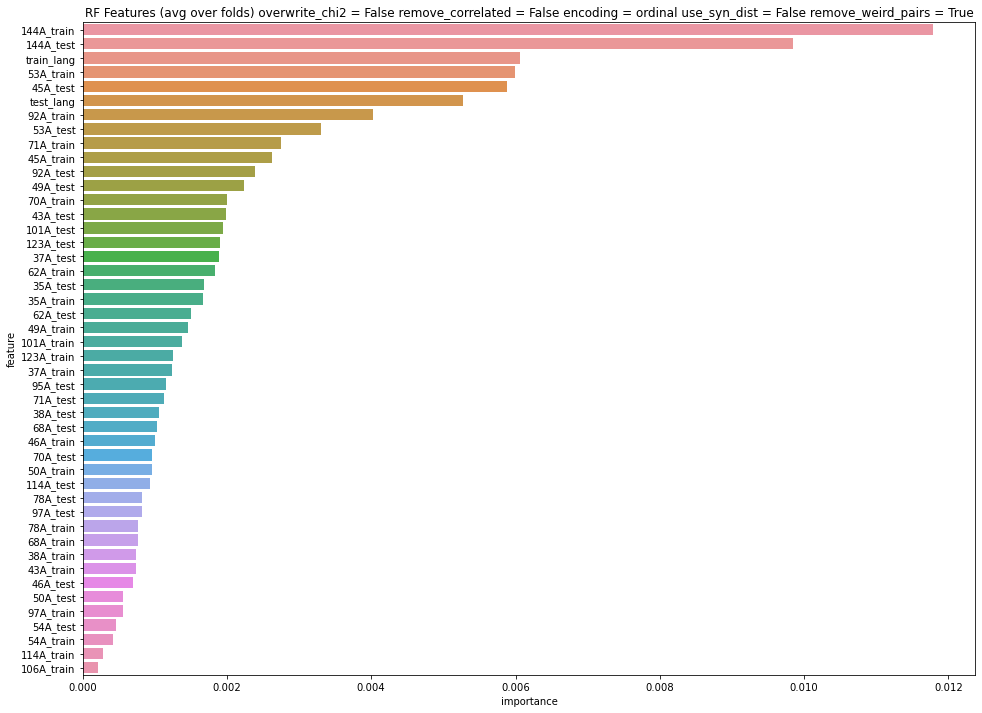

In [58]:
# ['linear','lasso','dt','rf','xgb']
for est in ['rf']:
    results, model = train_model(X,y,folds,params=None,model_type=est,plot_feature_importance=True)

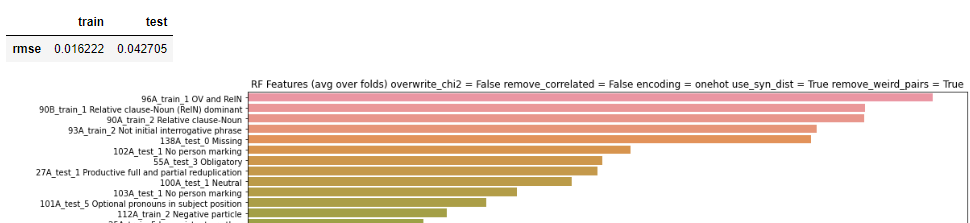

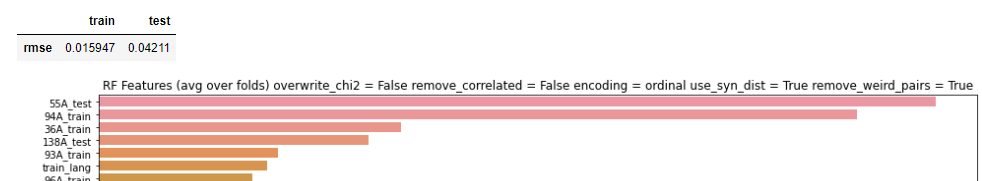

In [48]:
# REMOVE WEIRD PAIRS, ORDINAL

# Model type rf
# train	test
# rmse	0.015681	0 .041035
# Model type xgb
# train	test
# rmse	0.002217	0.039337

# REMOVE WEIRD PAIRS, ONE-HOT

# Model type rf
# train	test
# rmse	0.015878	0.042567
# Model type xgb
# train	test
# rmse	0.002146	0.040428

# KEEP WEIRD PAIRS, ORDINAL

# Model type rf
# train	test
# rmse	0.018733	0.049329
# Model type xgb
# train	test
# rmse	0.002024	0.046532

# KEEP WEIRD PAIRS, ONE-HOT

# Model type rf
# train	test
# rmse	0.018815	0.04925
# Model type xgb
# train	test
# rmse	0.002186	0.046337

In [49]:
final_df.shape

(661, 319)

XGBoost obtains slightly better results than RF, but the former overfits dramatically.

### Analysing feature importance

In [50]:
final_df.head()

,train_lang,test_lang,acc,f1,20A_train,21A_train,22A_train,23A_train,24A_train,25A_train,26A_train,27A_train,28A_train,29A_train,30A_train,31A_train,32A_train,33A_train,34A_train,35A_train,36A_train,37A_train,38A_train,39A_train,40A_train,41A_train,42A_train,43A_train,44A_train,45A_train,46A_train,47A_train,48A_train,49A_train,50A_train,51A_train,52A_train,53A_train,54A_train,55A_train,56A_train,57A_train,58A_train,59A_train,60A_train,61A_train,62A_train,63A_train,64A_train,65A_train,66A_train,67A_train,68A_train,69A_train,70A_train,71A_train,72A_train,73A_train,74A_train,75A_train,76A_train,77A_train,78A_train,79A_train,80A_train,81A_train,82A_train,83A_train,84A_train,85A_train,86A_train,87A_train,88A_train,89A_train,90A_train,91A_train,92A_train,93A_train,94A_train,95A_train,96A_train,97A_train,98A_train,99A_train,100A_train,101A_train,102A_train,103A_train,104A_train,105A_train,106A_train,107A_train,108A_train,109A_train,110A_train,111A_train,112A_train,113A_train,114A_train,115A_train,116A_train,117A_train,118A_train,119A_train,120A_train,121A_train,122A_train,123A_train,124A_train,125A_train,126A_train,127A_train,128A_train,129A_train,130A_train,131A_train,132A_train,133A_train,134A_train,135A_train,136A_train,137A_train,138A_train,142A_train,143F_train,90B_train,90C_train,144P_train,144J_train,144S_train,144X_train,144A_train,90E_train,144V_train,144I_train,144R_train,144M_train,144G_train,144K_train,144B_train,90D_train,144E_train,144D_train,81B_train,143E_train,143C_train,143A_train,144W_train,144Q_train,144L_train,144H_train,144C_train,144T_train,143G_train,137B_train,136B_train,109B_train,25B_train,21B_train,108B_train,58B_train,79B_train,20A_test,21A_test,22A_test,23A_test,24A_test,25A_test,26A_test,27A_test,28A_test,29A_test,30A_test,31A_test,32A_test,33A_test,34A_test,35A_test,36A_test,37A_test,38A_test,39A_test,40A_test,41A_test,42A_test,43A_test,44A_test,45A_test,46A_test,47A_test,48A_test,49A_test,50A_test,51A_test,52A_test,53A_test,54A_test,55A_test,56A_test,57A_test,58A_test,59A_test,60A_test,61A_test,62A_test,63A_test,64A_test,65A_test,66A_test,67A_test,68A_test,69A_test,70A_test,71A_test,72A_test,73A_test,74A_test,75A_test,76A_test,77A_test,78A_test,79A_test,80A_test,81A_test,82A_test,83A_test,84A_test,85A_test,86A_test,87A_test,88A_test,89A_test,90A_test,91A_test,92A_test,93A_test,94A_test,95A_test,96A_test,97A_test,98A_test,99A_test,100A_test,101A_test,102A_test,103A_test,104A_test,105A_test,106A_test,107A_test,108A_test,109A_test,110A_test,111A_test,112A_test,113A_test,114A_test,115A_test,116A_test,117A_test,118A_test,119A_test,120A_test,121A_test,122A_test,123A_test,124A_test,125A_test,126A_test,127A_test,128A_test,129A_test,130A_test,131A_test,132A_test,133A_test,134A_test,135A_test,136A_test,137A_test,138A_test,142A_test,143F_test,90B_test,90C_test,144P_test,144J_test,144S_test,144X_test,144A_test,90E_test,144V_test,144I_test,144R_test,144M_test,144K_test,144B_test,90D_test,144E_test,144D_test,81B_test,143E_test,143A_test,144W_test,144Q_test,144L_test,144H_test,144C_test,144T_test,143G_test,137B_test,136B_test,109B_test,25B_test,21B_test,108B_test,58B_test,79B_test,syn_dist
1,0.0,0.0,0.587932,0.517718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

#### With weird pairs

For one-hot encoding test rmse is 0.018815	and train is 0.04925. The most important feature is "34A Occurrence of Nominal Plurality" which distinguishes Japanese and Chinese from other languages.

For ordinal encoding, "55A_test" and "90B_train" are signficantly more important than other languages. Their full names are '55A Numeral Classifiers' and 90B Prenominal relative clauses.

#### Without weird pairs

Below we can see a visualization of a decision tree.

In [53]:
_, dt_model = train_model(X,y,folds,params=None,model_type='dt',plot_feature_importance=False)

Model type dt

Mean fold metrics


,train,test
rmse,0.056071,0.06008


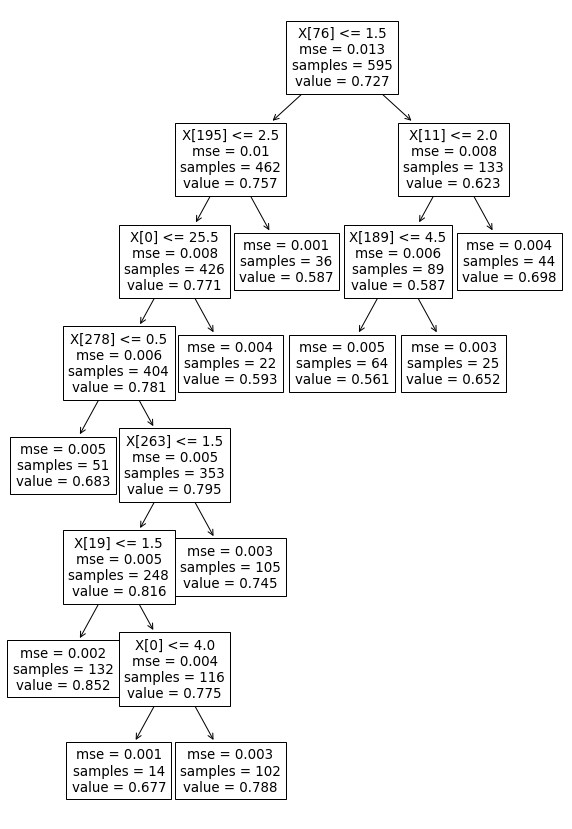

In [54]:
plt.figure(figsize=(10,15))
tree.plot_tree(dt_model);

In [55]:
X.columns[[195, 123, 259]]

Index(['55A_test', '90B_train', '119A_test'], dtype='object')

The two most important features are the same as for Random Forest. 

We can see that the languages with obligatory numeral classifiers are all from South-West Asia. On the other hand languages with missing feature 90B are usually European, while those that are not missing it are Asian.

#### By feature group

In [61]:
groups = {"morphology":list(range(20,30)),
"nom_cat":list(range(30, 58)),
"nom_synt":list(range(58, 65)),
"verb_cat":list(range(65, 81)),
"order":list(range(81, 98))+[143, 144],
"simp_claus":list(range(98, 122)),
"comp_sent":list(range(122, 129)),
"lexicon":list(range(129, 139)),
"other":list(range(141,143)),}


In [62]:
if encoding=="ordinal":
    final_feat_cols = final_df.columns[4:-1]
elif encoding=="onehot":
    final_feat_cols = final_df.columns[56:-1]
else:
    raise Exception("Select proper encoding.")

Group morphology
Model type rf

Mean fold metrics


,train,test
rmse,0.072227,0.087633


Group nom_cat
Model type rf

Mean fold metrics


,train,test
rmse,0.017872,0.046904


Group nom_synt
Model type rf

Mean fold metrics


,train,test
rmse,0.057115,0.079151


Group verb_cat
Model type rf

Mean fold metrics


,train,test
rmse,0.020234,0.055033


Group order
Model type rf

Mean fold metrics


,train,test
rmse,0.016393,0.040198


Group simp_claus
Model type rf

Mean fold metrics


,train,test
rmse,0.018982,0.049096


Group comp_sent
Model type rf

Mean fold metrics


,train,test
rmse,0.071364,0.092393


Group lexicon
Model type rf

Mean fold metrics


,train,test
rmse,0.039918,0.065147


Group other
Model type rf

Mean fold metrics


,train,test
rmse,0.109925,0.111144


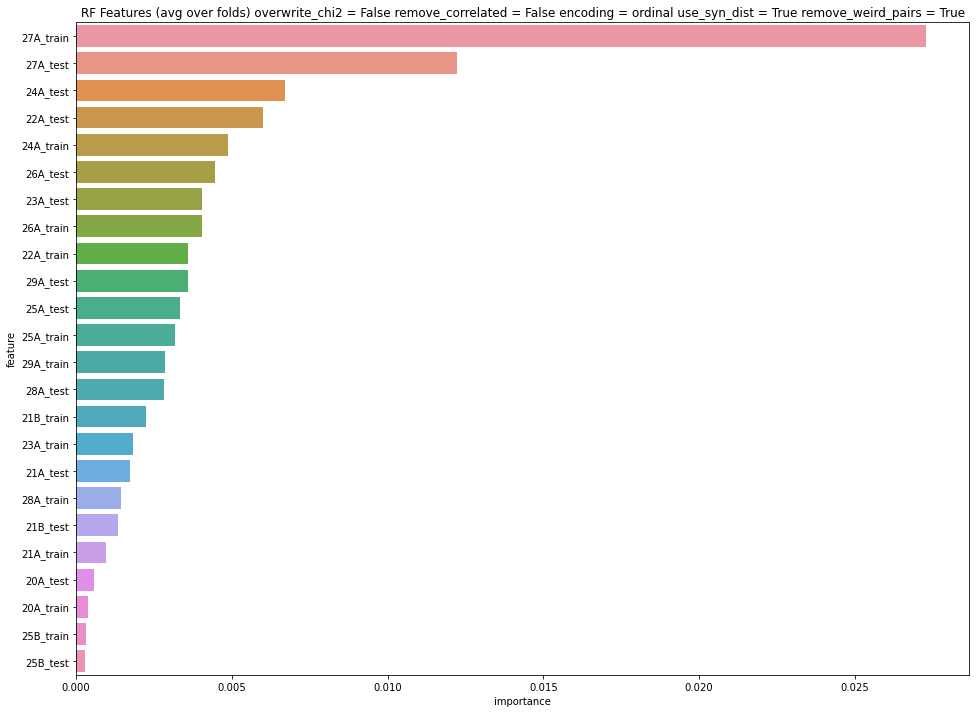

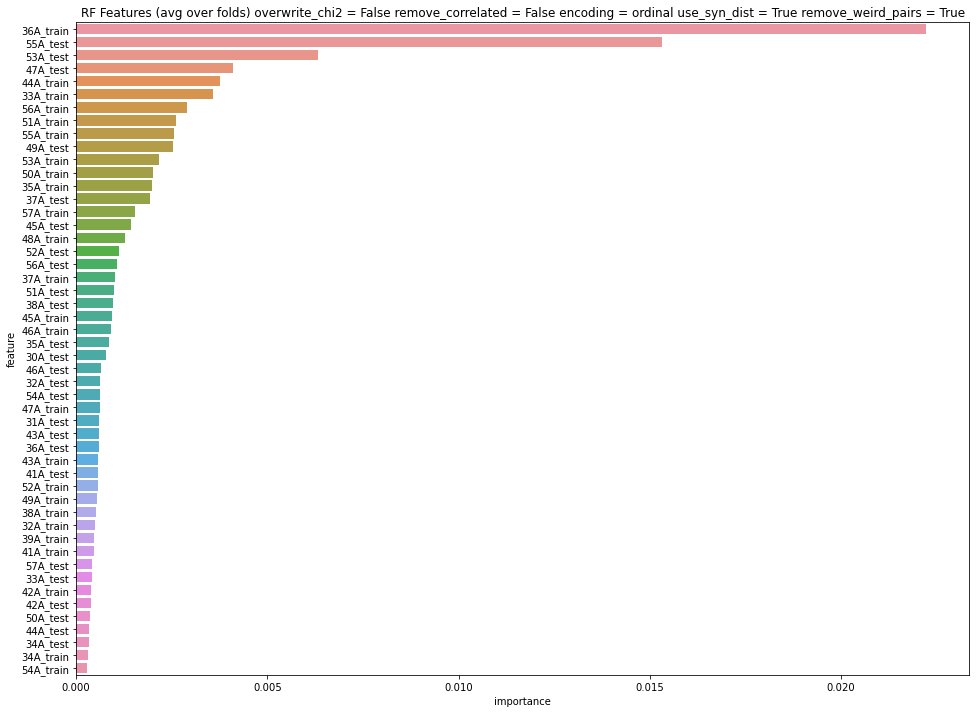

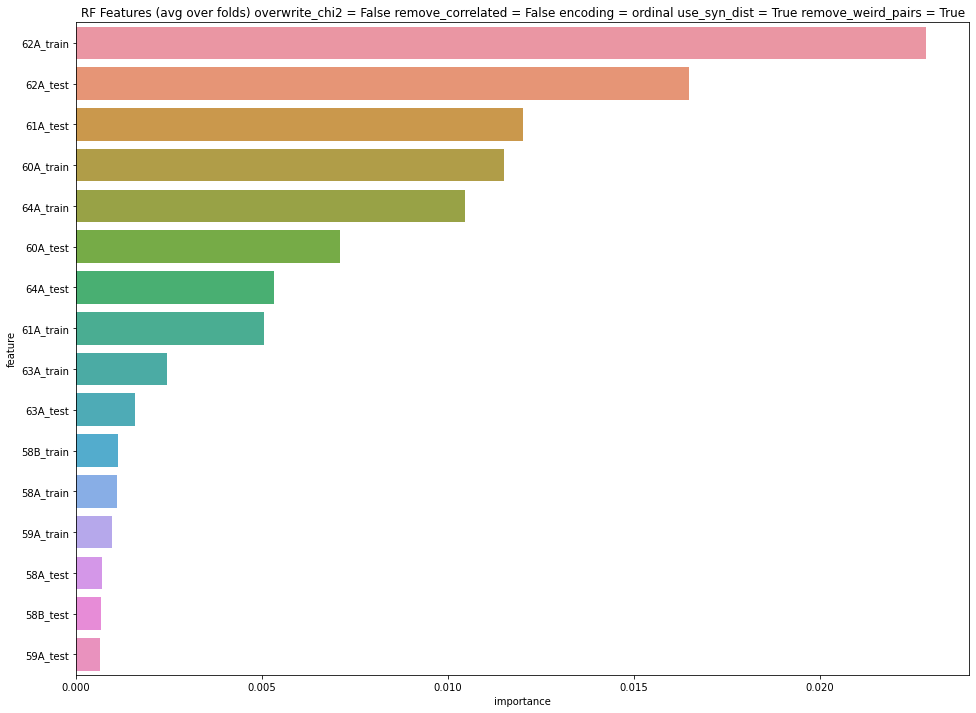

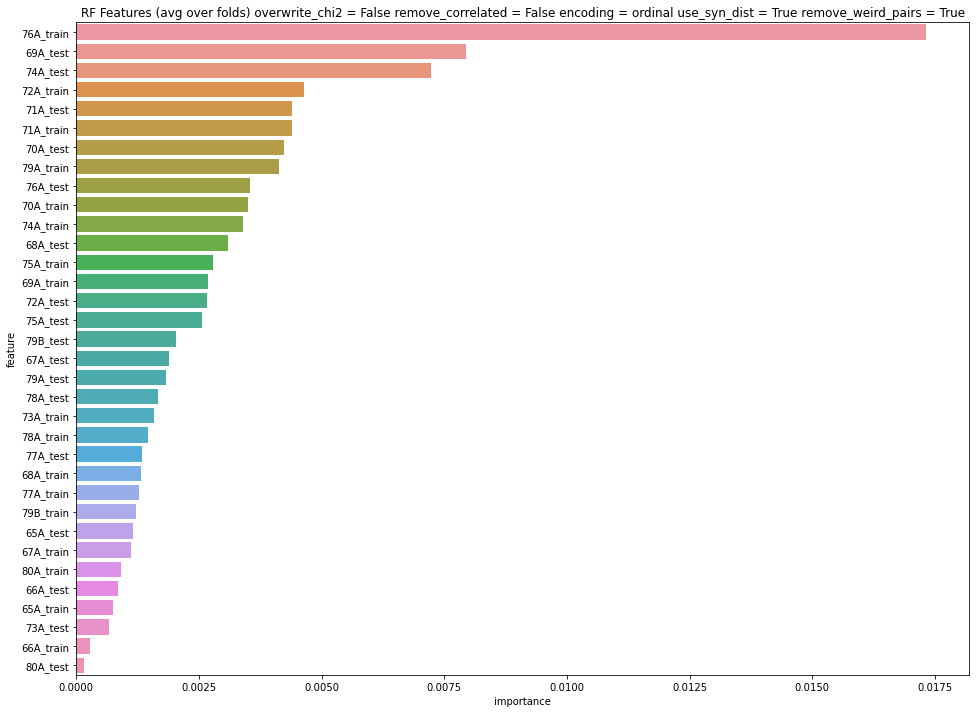

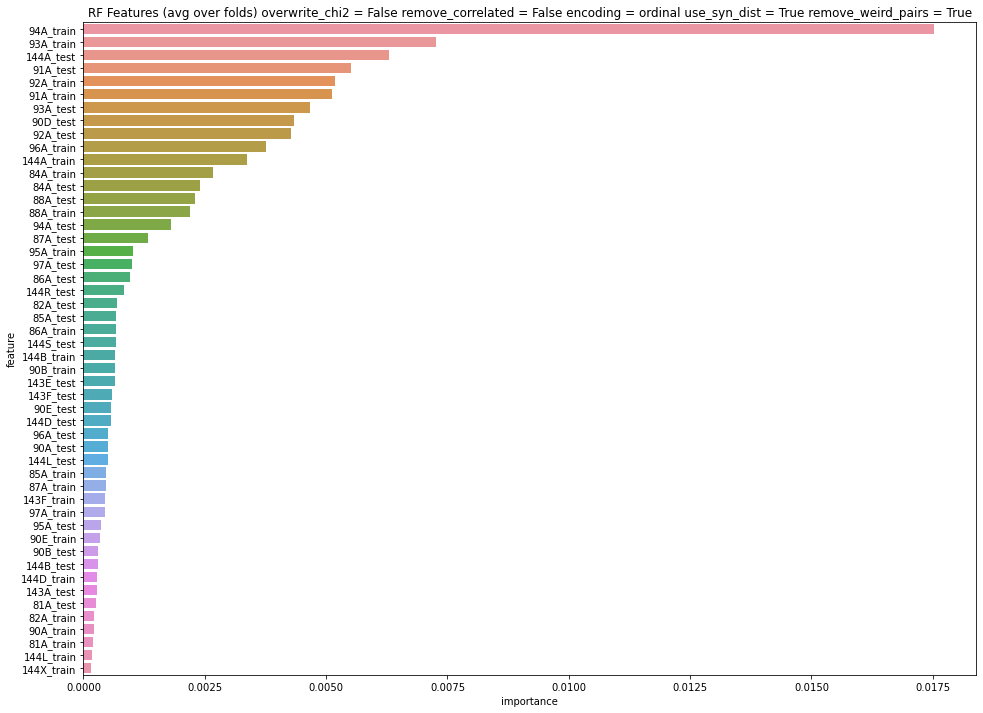

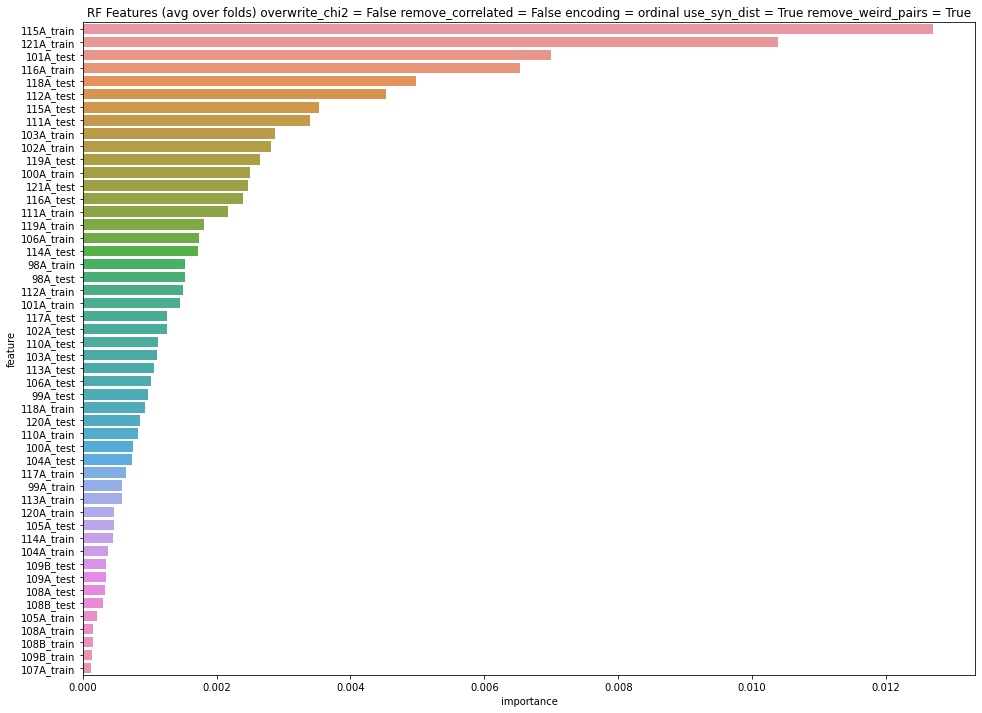

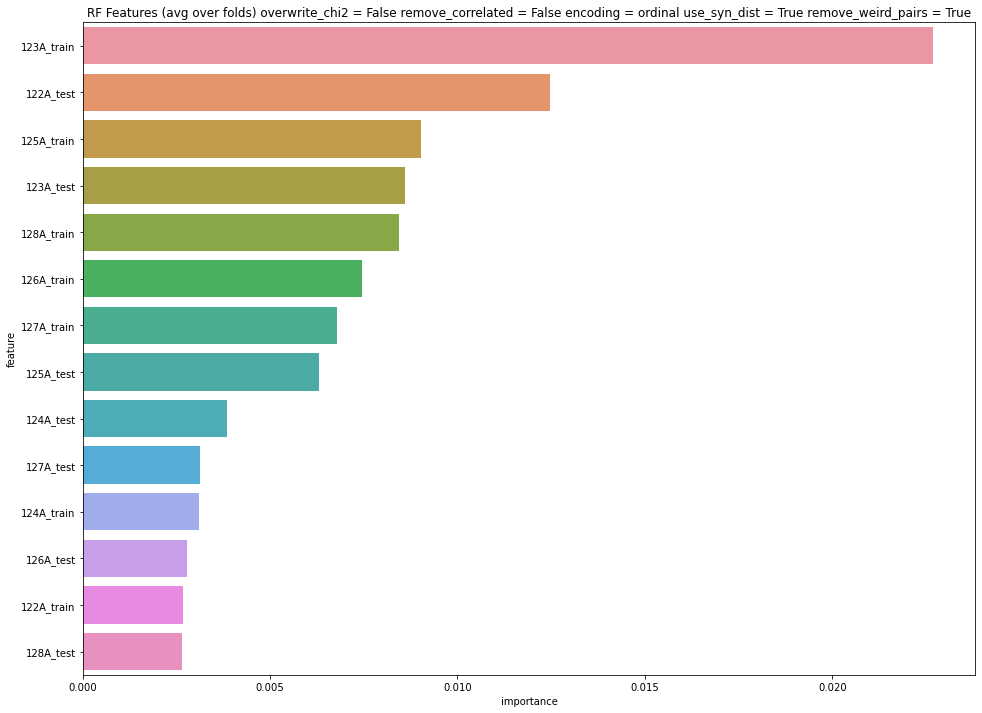

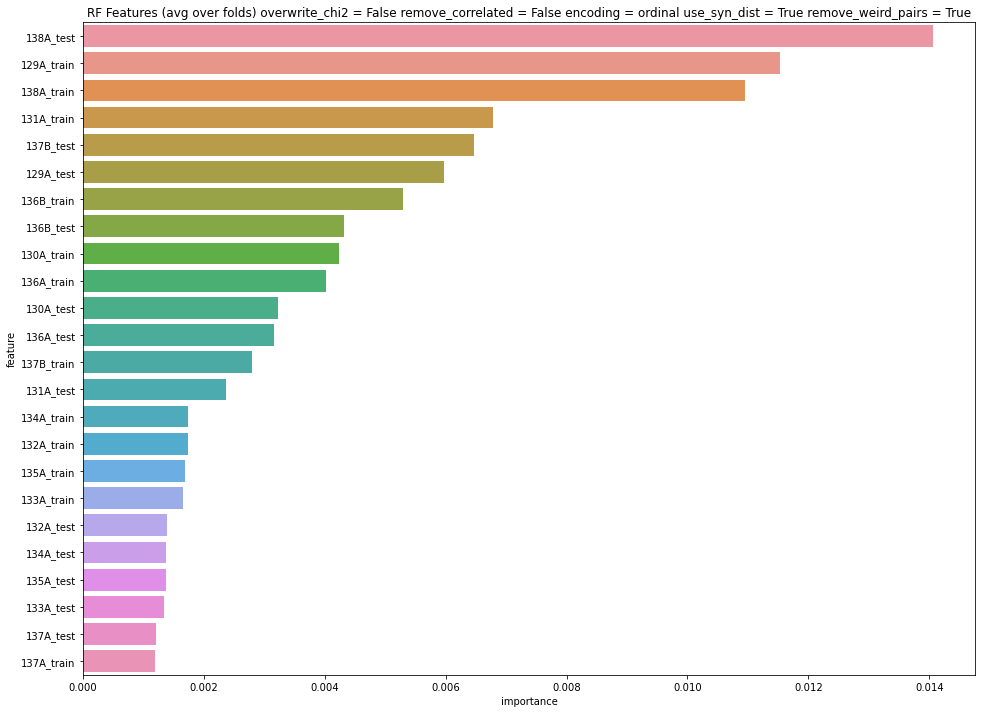

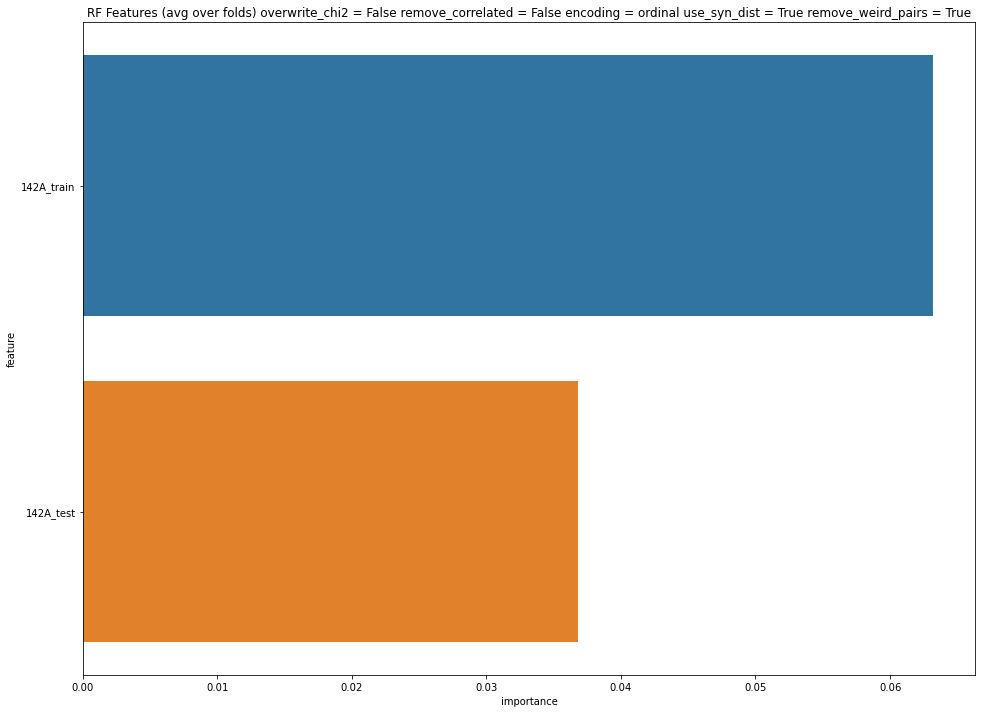

In [63]:

areas = []
metrics = []
for area in groups:
    group_range = groups[area]
    group_cols = [col for col in final_feat_cols if int(re.match("\d*", col).group()) in group_range]
    print("Group",area)
#     print("Cols",group_cols)
    X = final_df[group_cols]
    y = final_df['acc']
    results, model = train_model(X,y,folds,params=None,model_type='rf')
    areas.append(area)
    metrics.append(results['metrics'])

In [64]:
group_results = pd.concat(metrics)
group_results["group"] = areas

In [65]:
group_results.sort_values(by="test")

,train,test,group
rmse,0.016393,0.040198,order
rmse,0.017872,0.046904,nom_cat
rmse,0.018982,0.049096,simp_claus
rmse,0.020234,0.055033,verb_cat
rmse,0.039918,0.065147,lexicon
rmse,0.057115,0.079151,nom_synt
rmse,0.072227,0.087633,morphology
rmse,0.071364,0.092393,comp_sent
rmse,0.109925,0.111144,other


### Comparing to syntactical distance

#### Predict just with word order and syn_dist

Model type rf

Mean fold metrics


,train,test
rmse,0.017456,0.045664


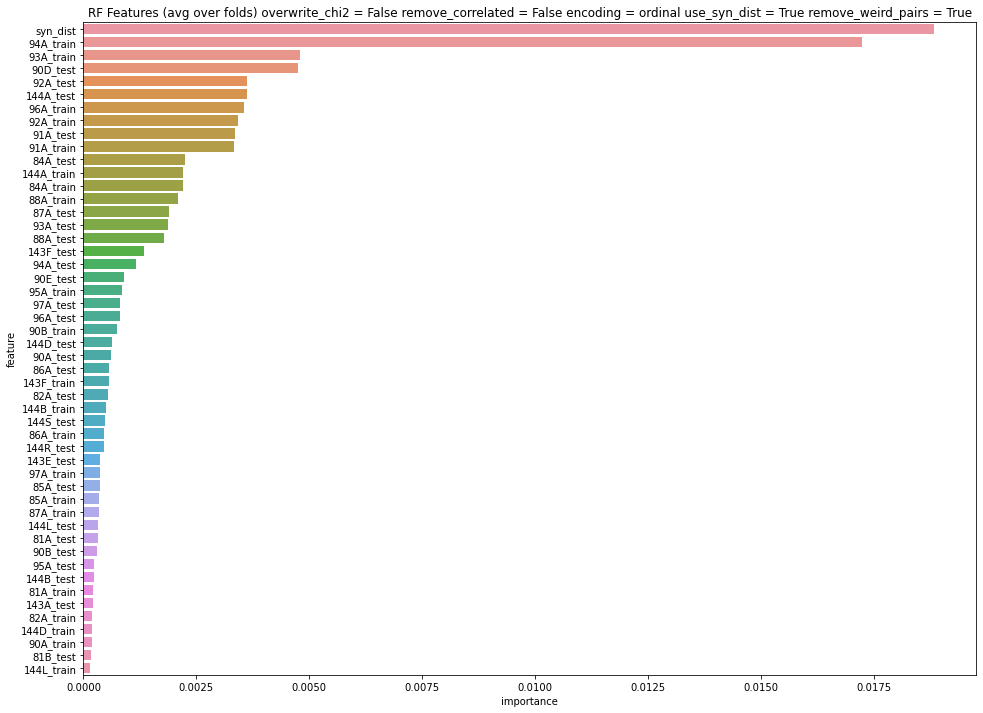

In [66]:
order_cols = [col for col in final_feat_cols if int(re.match("\d*", col).group()) in groups["order"]]
X = final_df[order_cols+["syn_dist"]]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

#### Predict with all features and syntactical distance

Model type rf

Mean fold metrics


,train,test
rmse,0.01582,0.040758


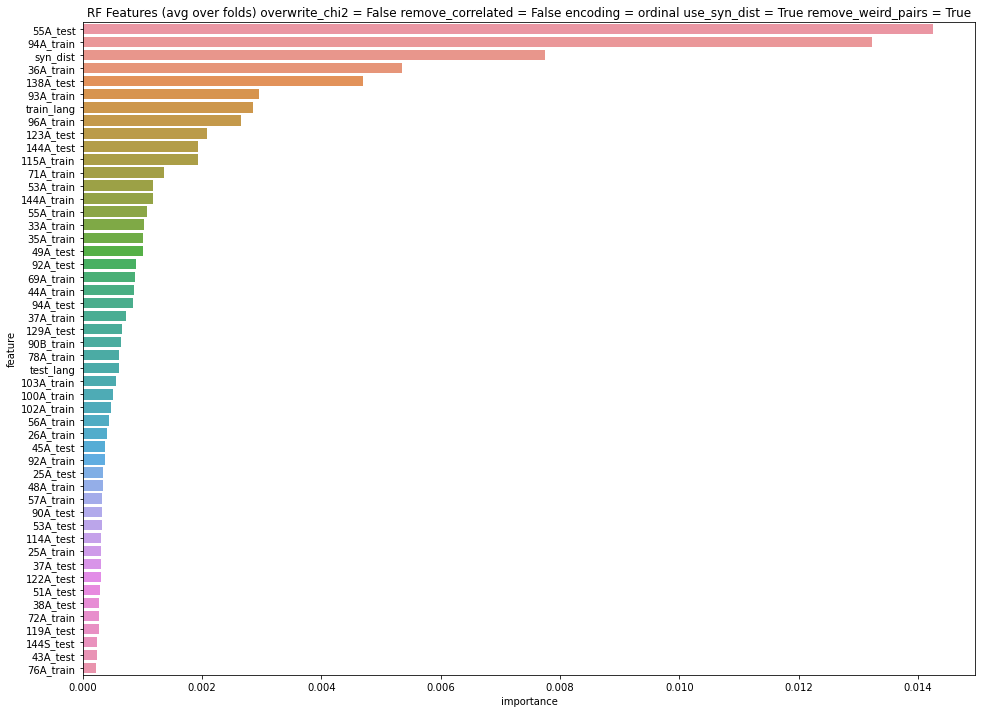

In [67]:
X = final_df.drop(['acc','f1'],axis=1)
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

#### Predict with only syntactical distance

In [68]:
def select_best_degree(train, test, predictor,target):
    def make_features(train_set, test_set, degrees):
        train_dict = {}
        test_dict = {}
        for d in degrees:
            traintestdict={}
            train_dict[d] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
            test_dict[d] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        return train_dict, test_dict
    
    xtrain = train[predictor].values
    ytrain = train[target].values
    xtest = test[predictor].values
    ytest = test[target].values
    
    degrees=range(30)
    
    train_dict, test_dict = make_features(xtrain, xtest, degrees)

    error_train=np.empty(len(degrees))
    error_test=np.empty(len(degrees))
    
#     for all degrees train and evaluate the polynomial model
    for d in degrees:
#         intercept/bias is already provided by PolynomialFeatures
        model = LinearRegression(fit_intercept=False)
        model.fit(train_dict[d],ytrain.reshape(-1,1))
        predtrain = model.predict(train_dict[d])
        predtest = model.predict(test_dict[d])
        error_train[d] = np.sqrt(mean_squared_error(ytrain,predtrain))
        error_test[d] = np.sqrt(mean_squared_error(ytest,predtest))
    
#     get the best degree
    best_degree = np.argmin(error_test)
    
#     plot errors on train and test set
    plot_errors=False
    if plot_errors:
        plt.figure(figsize=(8,6))
        plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
        plt.plot(degrees, error_test, marker='o', label='test')
        plt.axvline(best_degree, 0,0.5, color='r', label="min test error at d=%d"%best_degree, alpha=0.3)
        plt.ylabel('RMSE')
        plt.xlabel('degree')
        plt.legend(loc='upper right')
        plt.title("Errors of polynomial models with different degrees for {}".format(target))
        plt.xticks(range(0,20,2))
    #     plt.savefig(f"{IMAGES_DIR}best_degree_{target}.jpg",dpi=500, bbox_inches = 'tight',pad_inches = 0)
        plt.yscale("log")
        print("Best degree",best_degree)
    return best_degree

In [69]:
best_degrees = []
for i in range(100):
    train, test = train_test_split(final_df[['syn_dist','acc']])
    best_degrees.append(select_best_degree(train, test, 'syn_dist','acc'))

In [70]:
best_degree_counts = pd.Series(best_degrees).value_counts()
best_degree_counts

9     16
23    14
1     11
11    10
19     5
13     5
27     5
3      5
15     4
10     4
8      4
5      4
28     3
16     2
6      2
2      2
20     1
14     1
24     1
4      1
dtype: int64

In [71]:
X = final_df[['syn_dist']]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='linear',plot_feature_importance=False)

Model type linear

Mean fold metrics


,train,test
rmse,0.09976,0.099831


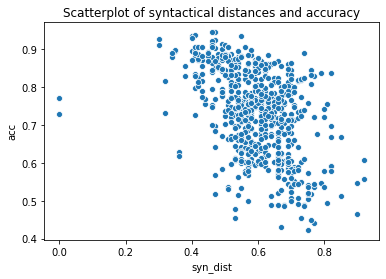

In [72]:
sns.scatterplot(x='syn_dist',y='acc',data=final_df)
plt.title("Scatterplot of syntactical distances and accuracy")
plt.show()

Pearson correlation between accuracy and syntactical distance

In [73]:
from scipy import stats

stats.pearsonr(final_df['acc'], final_df['syn_dist'])

(-0.4675910995579578, 3.2684975750969716e-37)

### Predicting only with "A" features

Model type rf

Mean fold metrics


,train,test
rmse,0.016007,0.042158


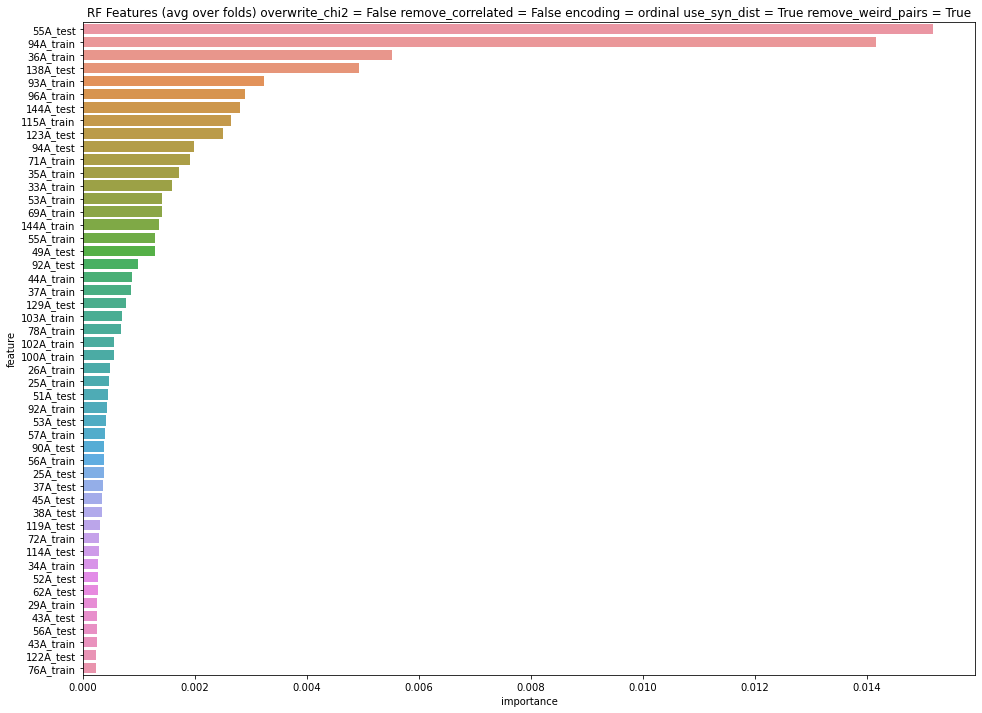

In [74]:
a_feats = [col for col in final_feat_cols if col.split("_")[0][-1]=="A"]

X = final_df[a_feats]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

### Predicting only with WBO features 

Model type rf

Mean fold metrics


,train,test
rmse,0.073116,0.085102


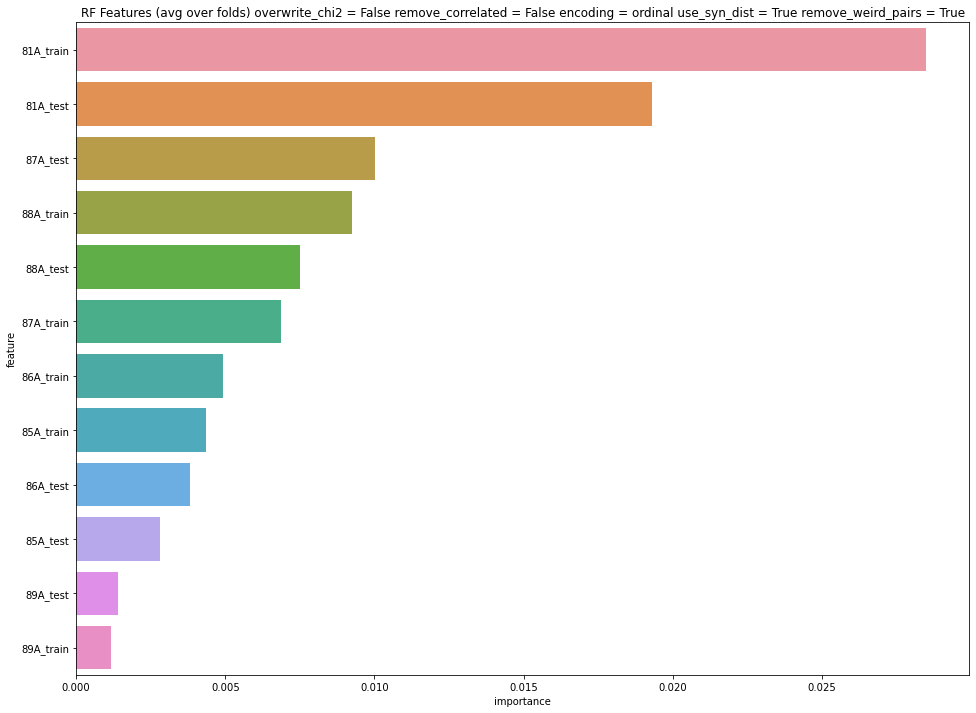

In [75]:
wbo = ['81A Order of Subject, Object and Verb',
'85A Order of Adposition and Noun Phrase',
'86A Order of Genitive and Noun',
'87A Order of Adjective and Noun',
'88A Order of Demonstrative and Noun',
'89A Order of Numeral and Noun']

wbo_cols = [col.split()[0]+"_train" for col in wbo]+ [col.split()[0]+"_test" for col in wbo]

X = final_df[wbo_cols]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

## Draft

In [ ]:
# params = {
#         'max_depth':3,
#         'min_child_weight':1,
#         'scale_pos_weight':weight_ratio,
#         'objective':'binary'
# }

In [ ]:
# split = int(0.9*final_df.shape[0])
# train = final_df.iloc[:split,:]
# test = final_df.iloc[split:,:]
# train.shape,test.shape

In [ ]:
final_df.shape

### XGB hyperparameter tuning - Random Search

In [ ]:
xgb_model = xgb.XGBRegressor()
distributions = {
    "n_estimators":[2,5,10,50,100],
    "max_depth":[3,4,5,8,10],
    "min_child_weight":[1,2,5]
#     lambda:
    
}

exhaustive = 1
for k in distributions:
    exhaustive *= len(distributions[k])
    
print(exhaustive)

random_search = RandomizedSearchCV(xgb_model, distributions, cv=10,n_iter=exhaustive,random_state=0,scoring='neg_mean_squared_error')
search = random_search.fit(X,y)

pd.DataFrame.from_dict(search.cv_results_)

params = search.best_params_

### Show column values

In [64]:
cols = ['22A Inflectional Synthesis of the Verb','30A Number of Genders','29A Syncretism in Verbal Person/Number Marking','43A Third Person Pronouns and Demonstratives']
for col in cols:
    print("Column",col)
    print("Values:")
    for val in sorted(lang_feats[col].dropna().unique(), key=lambda element: [element[0]]):
        print(val)
    print()

Column 22A Inflectional Synthesis of the Verb
Values:
1 0-1 category per word
2 2-3 categories per word
3 4-5 categories per word
4 6-7 categories per word
5 8-9 categories per word

Column 30A Number of Genders
Values:
1 None
2 Two
3 Three
5 Five or more

Column 29A Syncretism in Verbal Person/Number Marking
Values:
1 No subject person/number marking
2 Syncretic
3 Not syncretic

Column 43A Third Person Pronouns and Demonstratives
Values:
1 Unrelated
2 Related for all demonstratives
3 Related to remote demonstratives
5 Related by gender markers
6 Related for non-human reference



### Kruskal and anova

In [46]:
import scipy.stats as stats
num_significant = {"anova":0,"kruskal":0}
alpha = 0.05
for col in feat_cols:
    col_df = final_df[[col,'acc']].dropna()
    if col_df[col].nunique()>1:
        groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
        num_significant["kruskal"] += stats.kruskal(*groups).pvalue<alpha
#         print(stats.f_oneway(*groups).statistic,stats.f_oneway(*groups).pvalue)

### Stepwise selection

In [39]:
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [40]:
params= {"learning_rate":0.1,
"max_depth":4}

model = xgb.XGBRegressor(**params,random_state=SEED)

sfs_xgb = sfs(model,
           k_features=X.shape[1]-1,
           forward=True,
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           n_jobs=7,
           cv=5)

# Perform SFFS
sfs_result = sfs_xgb.fit(X, y)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:    5.5s
[Parallel(n_jobs=7)]: Done 316 out of 316 | elapsed:    9.3s finished

[2020-06-14 11:49:37] Features: 1/315 -- score: -0.010088892269037702[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:    4.8s
[Parallel(n_jobs=7)]: Done 315 out of 315 | elapsed:   10.1s finished

[2020-06-14 11:49:47] Features: 2/315 -- score: -0.0061244179688339055[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:    5.9s
[Parallel(n_jobs=7)]: Done 314 out of 314 | elapsed:   12.9s finished

[2020-06-14 11:50:00] Features: 3/315 -- score: -0.004601

[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   15.2s
[Parallel(n_jobs=7)]: Done 292 out of 292 | elapsed:   30.8s finished

[2020-06-14 11:58:06] Features: 25/315 -- score: -0.0028584317526725495[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    3.2s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   16.7s
[Parallel(n_jobs=7)]: Done 291 out of 291 | elapsed:   31.6s finished

[2020-06-14 11:58:38] Features: 26/315 -- score: -0.0028367702557727118[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    2.9s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   15.9s
[Parallel(n_jobs=7)]: Done 290 out of 290 | elapsed:   30.2s finished

[2020-06-14 11:59:09] Features: 27/315 -- score: -0.0028344559517207036[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | 

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    8.0s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   44.0s
[Parallel(n_jobs=7)]: Done 267 out of 267 | elapsed:  1.3min finished

[2020-06-14 12:22:33] Features: 50/315 -- score: -0.002652981302422356[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    8.3s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   47.3s
[Parallel(n_jobs=7)]: Done 266 out of 266 | elapsed:  1.4min finished

[2020-06-14 12:23:56] Features: 51/315 -- score: -0.0026608130442405302[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    8.9s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   49.5s
[Parallel(n_jobs=7)]: Done 265 out of 265 | elapsed:  1.4min finished

[2020-06-14 12:25:23] Features: 52/315 -- score: -0.0026600132028504527[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 conc

[Parallel(n_jobs=7)]: Done 243 out of 243 | elapsed:  1.7min finished

[2020-06-14 12:58:38] Features: 74/315 -- score: -0.002642653030186936[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   11.6s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 242 out of 242 | elapsed:  1.7min finished

[2020-06-14 13:00:19] Features: 75/315 -- score: -0.002656669250408562[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   11.5s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 241 out of 241 | elapsed:  1.7min finished

[2020-06-14 13:02:01] Features: 76/315 -- score: -0.002643754333872703[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   11.9s
[Parallel(n_jobs=7)]: Done 148 tasks      | ela

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   10.5s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   56.7s
[Parallel(n_jobs=7)]: Done 218 out of 218 | elapsed:  1.4min finished

[2020-06-14 13:35:27] Features: 99/315 -- score: -0.0026831882878050003[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   10.5s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   57.4s
[Parallel(n_jobs=7)]: Done 217 out of 217 | elapsed:  1.4min finished

[2020-06-14 13:36:49] Features: 100/315 -- score: -0.0026488302445419913[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   10.6s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   58.0s
[Parallel(n_jobs=7)]: Done 216 out of 216 | elapsed:  1.4min finished

[2020-06-14 13:38:11] Features: 101/315 -- score: -0.0026453496321697956[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 c

[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 194 out of 194 | elapsed:  1.3min finished

[2020-06-14 14:08:31] Features: 123/315 -- score: -0.0026406895788039174[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   11.4s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 193 out of 193 | elapsed:  1.3min finished

[2020-06-14 14:09:52] Features: 124/315 -- score: -0.0026691955522421358[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   12.0s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 192 out of 192 | elapsed:  1.3min finished

[2020-06-14 14:11:11] Features: 125/315 -- score: -0.0026400058814083516[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks     

[Parallel(n_jobs=7)]: Done 170 out of 170 | elapsed:  1.4min finished

[2020-06-14 14:41:16] Features: 147/315 -- score: -0.002701735256306711[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   14.2s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 169 out of 169 | elapsed:  1.4min finished

[2020-06-14 14:42:43] Features: 148/315 -- score: -0.00268589528174825[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   14.4s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 168 out of 168 | elapsed:  1.4min finished

[2020-06-14 14:44:08] Features: 149/315 -- score: -0.0026792834687214134[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   14.5s
[Parallel(n_jobs=7)]: Done 148 tasks      | 

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   17.8s
[Parallel(n_jobs=7)]: Done 142 out of 142 | elapsed:  1.5min finished

[2020-06-14 15:20:00] Features: 175/315 -- score: -0.002841851219855395[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   18.6s
[Parallel(n_jobs=7)]: Done 141 out of 141 | elapsed:  1.5min finished

[2020-06-14 15:21:33] Features: 176/315 -- score: -0.002907833347146115[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   18.5s
[Parallel(n_jobs=7)]: Done 140 out of 140 | elapsed:  1.5min finished

[2020-06-14 15:23:06] Features: 177/315 -- score: -0.0028843263884100177[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   18.9s
[Parallel(n_jobs=7)]: Done 139 out of 139 | elapsed:  1.5min finished

[2020-06-14 15:24:39] Features: 1

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   19.6s
[Parallel(n_jobs=7)]: Done 112 out of 112 | elapsed:  1.3min finished

[2020-06-14 16:05:17] Features: 205/315 -- score: -0.003205248899680821[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   19.3s
[Parallel(n_jobs=7)]: Done 111 out of 111 | elapsed:  1.3min finished

[2020-06-14 16:06:34] Features: 206/315 -- score: -0.0032472469218404534[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   19.7s
[Parallel(n_jobs=7)]: Done 110 out of 110 | elapsed:  1.3min finished

[2020-06-14 16:07:54] Features: 207/315 -- score: -0.00333623072789148[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   20.9s
[Parallel(n_jobs=7)]: Done 109 out of 109 | elapsed:  1.4min finished

[2020-06-14 16:09:16] Features: 20

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   20.3s
[Parallel(n_jobs=7)]: Done  82 out of  82 | elapsed:   59.2s finished

[2020-06-14 16:42:17] Features: 235/315 -- score: -0.0030521192007352048[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   20.3s
[Parallel(n_jobs=7)]: Done  81 out of  81 | elapsed:   58.9s finished

[2020-06-14 16:43:16] Features: 236/315 -- score: -0.003052601778545827[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   20.4s
[Parallel(n_jobs=7)]: Done  80 out of  80 | elapsed:   58.7s finished

[2020-06-14 16:44:15] Features: 237/315 -- score: -0.00306158071000242[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   20.6s
[Parallel(n_jobs=7)]: Done  79 out of  79 | elapsed:   58.5s finished

[2020-06-14 16:45:13] Features: 23

[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   23.1s
[Parallel(n_jobs=7)]: Done  52 out of  52 | elapsed:   43.5s finished

[2020-06-14 17:08:12] Features: 265/315 -- score: -0.003366225151640105[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   22.9s
[Parallel(n_jobs=7)]: Done  51 out of  51 | elapsed:   43.5s finished

[2020-06-14 17:08:56] Features: 266/315 -- score: -0.003416493499419704[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   23.2s
[Parallel(n_jobs=7)]: Done  50 out of  50 | elapsed:   42.3s finished

[2020-06-14 17:09:38] Features: 267/315 -- score: -0.0035347808827199236[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   23.1s
[Parallel(n_jobs=7)]: Done  49 out of  49 | elapsed:   40.0s finished

[2020-06-14 17:10:18] Features: 2

[Parallel(n_jobs=7)]: Done  16 out of  19 | elapsed:   17.5s remaining:    3.2s
[Parallel(n_jobs=7)]: Done  19 out of  19 | elapsed:   17.9s finished

[2020-06-14 17:25:12] Features: 298/315 -- score: -0.0051242071461152176[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  15 out of  18 | elapsed:   17.0s remaining:    3.3s
[Parallel(n_jobs=7)]: Done  18 out of  18 | elapsed:   17.3s finished

[2020-06-14 17:25:29] Features: 299/315 -- score: -0.005155058840512559[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  13 out of  17 | elapsed:   13.2s remaining:    4.0s
[Parallel(n_jobs=7)]: Done  17 out of  17 | elapsed:   17.1s finished

[2020-06-14 17:25:47] Features: 300/315 -- score: -0.005145832623874724[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  12 out of  16 | elapsed:   12.7s remaining:    4.2s
[Parallel(n_jobs=7)]: Done  

In [41]:
scores = [sfs_result.subsets_[k]["avg_score"] for k in sfs_result.subsets_]

In [42]:
np.argmax(scores)

86

In [44]:
best_stepwise = list(sfs_result.subsets_[np.argmax(scores)+1]['feature_names'])

In [45]:

import datetime 
  
now = datetime.datetime.now() 
now = now.strftime("%d_%m_%Y_%H_%M")
with open("forward_selection_{}.txt".format(now), "w") as f:
    n = f.write(str(sfs_result.subsets_))

### MRMR - feature selection

In [ ]:
from skfeature.function.information_theoretical_based import MRMR
m = MRMR.mrmr(final_df.drop(['acc','f1'],axis=1).to_numpy(),final_df['acc'])
mrmr_top50 = [final_df.drop(['acc','f1'],axis=1).columns[i] for i in m[0][:50]]
print("Top 50 features selected by MRMR")
print(mrmr_top50)

### Display geographical map of languages

In [ ]:

plt.figure(figsize=(20,10))

p1 = sns.scatterplot(x="longitude", y="latitude", data=lang_feats)
for line in range(0,lang_feats.shape[0]):
     p1.text(lang_feats.longitude[line]+0.01, lang_feats.latitude[line], 
     lang_feats.Name[line], horizontalalignment='left', 
     size='large', color='black')

### Display important features

In [ ]:
important_features = ["55A Numeral Classifiers","96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun",
                     "94A Order of Adverbial Subordinator and Clause","93A Position of Interrogative Phrases in Content Questions","138A Tea"]
for feat in important_features:
    print()
    print(feat)
    for val in lang_feats[feat].unique():
        print(val)
        if not isinstance(val, str) and np.isnan(val):
            print(lang_feats[lang_feats[feat].isna()].Name.unique())
        else:
            print(lang_feats[lang_feats[feat]==val].Name.unique())